# Introduction

I'm trying to understand Rafa's QC metrics.

I thought I should try to replicate the correlations for two libraries that did poorly. I'm using ENCSR950BNG from http://wiki.encodedcc.org/index.php/File:Lrna_qc_all.xlsx which is "Total RNA-seq on postnatal 0 day mouse liver (13pgs)"

I downloaded the RSEM Gene quantification TSV files ENCFF923KGS.tsv, ENCFF023RHI.tsv

# Python setup

Skip down to <a href="#How many non zeros"> if you're not a python programmer.

In [1]:
from __future__ import print_function
import pandas
import numpy
import os
import scipy.stats
import matplotlib.pyplot as plt

%load_ext rmagic
%matplotlib inline

def load_rsem_reps(name1, name2, column, root=None):
    """Load two RSEM quantifications and and return the two scores as a dataframe.
    """
    if root is None:
        root = os.path.expanduser('~/dl/')

    rep1 = pandas.read_csv(os.path.join(root, name1), sep='\t', index_col=0)
    rep2 = pandas.read_csv(os.path.join(root, name2), sep='\t', index_col=0)
    
    reps = pandas.DataFrame({'rep1': rep1['FPKM'],
                             'rep2': rep2['FPKM']},
                            index=rep1.index)
    return reps

def score_replicates(reps, filtered):
    if filtered is None:
        rep1 = reps['rep1']
        rep2 = reps['rep2']
    else:
        rep1 = filtered['rep1']
        rep2 = filtered['rep2']

    scores = pandas.Series({
        'total rows': len(reps),
        'passed filter': len(rep1),
        'Pearson': scipy.stats.pearsonr(rep1, rep2)[0],
        'Spearman': scipy.stats.spearmanr(rep1, rep2)[0]
    },
    index = ['total rows', 'passed filter', 'Pearson', 'Spearman']
    )
    return scores

def plot_cumsum_replicates(rep1, rep2, column):
    """Make side-by-side cumulative sum plot
    """
    f = plt.figure("12", figsize=(10,5))

    plt.subplot("121")
    plt.title("Rep 1")
    plt.ylabel("Cum sum {}".format(column))
    plt.xlabel("datapoints seen")
    plt.plot(numpy.cumsum(sorted(rep1)))

    plt.subplot("122")
    plt.title("Rep 2")
    plt.xlabel("datapoints seen")
    plt.plot(numpy.cumsum(sorted(rep2)))

def plot_spikes(rep1, rep2):
    spikes = [ x.startswith('gSpikein') for x in rep1.index ]
    plt.title('Spikes (n={})'.format(len(rep1[spikes])))
    plt.xlabel('rep 1 $log_2$ filtered')
    plt.ylabel('rep 2 $log_2$ filtered')
    plt.scatter(rep1[spikes], rep2[spikes], c='y')
    
    xlim = plt.xlim()
    xmin, xmax = int(xlim[0]), int(xlim[1])
    plt.plot(range(xmin, xmax), range(xmin, xmax), 'k', label='$y = x$')
    plt.legend()

# Load RSEM Gene Quantifications

In [2]:
reps = load_rsem_reps('ENCFF923KGS.tsv', 'ENCFF023RHI.tsv', 'FPKMS')

# How many non-zeros

In [3]:
print("rep1 > 0: ", len(reps['rep1'][reps['rep1'] > 0]))
print("rep2 > 0: ", len(reps['rep2'][reps['rep2'] > 0]))
print("Total rows:", len(reps['rep1']))

rep1 > 0:  8642
rep2 > 0:  7350
Total rows: 69690


# Scatter plot of raw FPKM values

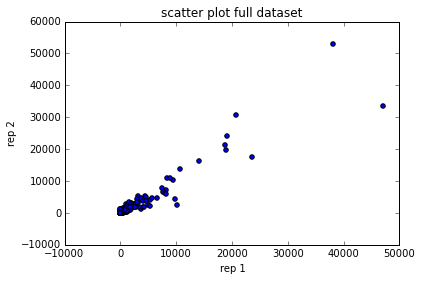

In [4]:
plt.title("scatter plot full dataset")
plt.xlabel("rep 1")
plt.ylabel("rep 2")
_ = plt.scatter(reps['rep1'], reps['rep2'])

Well that was hard to visualize... lets try a smaller view

# Zoomed in scatter plot of raw FPKM values

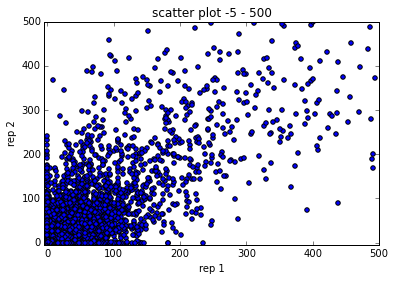

In [5]:
plt.title("scatter plot -5 - 500")
plt.xlim(-5, 500)
plt.ylim(-5, 500)
plt.xlabel("rep 1")
plt.ylabel("rep 2")

_ = plt.scatter(reps['rep1'], reps['rep2']),

# Cumulative sum of sorted FPKM values

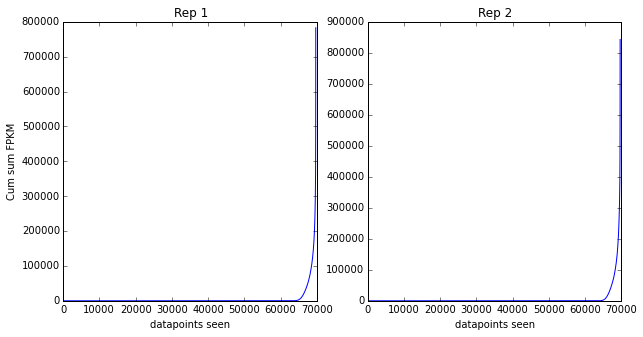

In [6]:
plot_cumsum_replicates(reps['rep1'], reps['rep2'], 'FPKM')

I was trying to visualize how many zeros and small values we have. This plot is a "sorted cumulative sum". The x axis is the number of data points seen so far, the y axis is the sum of all data points seen so far.

# Naïve Correlation

Compute correlations on the FPKM column, without any transformations. I did not drop zeros, log transform, threshold or do any other manipulation.

In [7]:
naive_scores = score_replicates(reps, None)
pandas.DataFrame(naive_scores)

,0
total rows,69690.000000
passed filter,69690.000000
Pearson,0.949737
Spearman,0.655810


# Drop double zeros

Remove rows where both replicates are zero.

In [8]:
bothzero = (reps['rep1'] == 0) & (reps['rep2'] == 0)
bothzero_reps = reps[bothzero != True]

bothzero_score = score_replicates(reps, bothzero_reps)
pandas.DataFrame(bothzero_score)

,0
total rows,69690.000000
passed filter,10601.000000
Pearson,0.949396
Spearman,0.305444


## Scatter plot of log 2 transformed data with double zeros removed

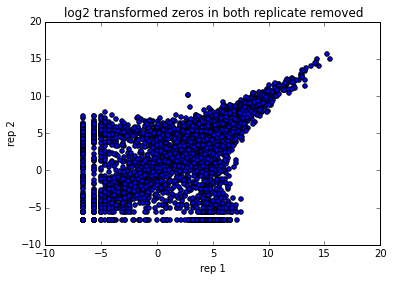

In [9]:
plt.title("log2 transformed zeros in both replicate removed")
plt.xlabel("rep 1")
plt.ylabel("rep 2")

_ = plt.scatter(numpy.log2(bothzero_reps['rep1']), 
                numpy.log2(bothzero_reps['rep2']))

## Cumulative sum when double-zeros are dropped

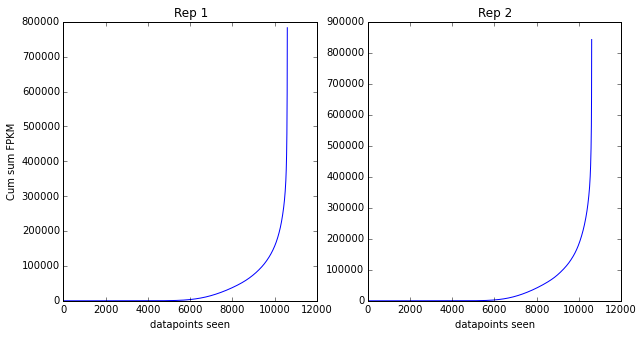

In [10]:
plot_cumsum_replicates(bothzero_reps['rep1'], bothzero_reps['rep2'], 'FPKM')

# Drop rows where either replicate contains a zero

In [11]:
nozero = (reps['rep1'] == 0) | (reps['rep2'] == 0)
nozero_reps = reps[nozero != True]

nozero_scores = score_replicates(reps, nozero_reps)
pandas.DataFrame(nozero_scores)

,0
total rows,69690.000000
passed filter,5391.000000
Pearson,0.949233
Spearman,0.633321


## Cumulative sum with zero values in either replicate removed

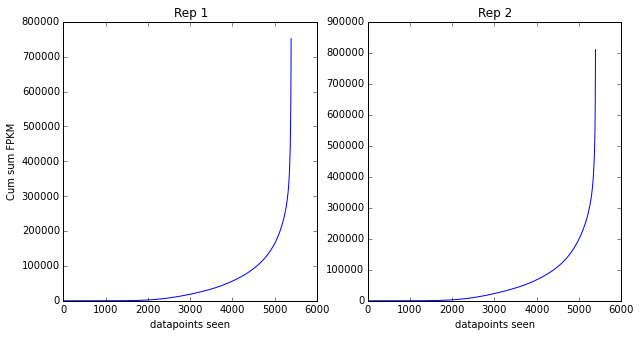

In [12]:
plot_cumsum_replicates(nozero_reps['rep1'], nozero_reps['rep2'], 'FPKM')

## Correlations of log2 transformed data with zero values in either replicate removed

In [13]:
logrep = numpy.log2(nozero_reps)

logrep_scores = score_replicates(reps, logrep)
pandas.DataFrame(logrep_scores)

,0
total rows,69690.000000
passed filter,5391.000000
Pearson,0.521577
Spearman,0.633321


But wait there's still another filter!

# Rafa's QC R script in python

In addition to being used for Rafa's MA metric, he also applies the filter below to the correlation metrics. (In addition to throwing out all rows with a zero measurement)

$\frac{log_2(rep1) + log_2(rep2)}{2} < 0$

In [14]:
Acutoff = 0

M = logrep['rep1'] - logrep['rep2']
A = (logrep['rep1'] + logrep['rep2']) / 2.0

cutrep = logrep[A > Acutoff]

print("MAD of log ratios: ", numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3))
print("SD of log ratios:", numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3))

cutrep_scores = score_replicates(reps, cutrep)
pandas.DataFrame(cutrep_scores)


MAD of log ratios:  1.526
SD of log ratios: 3.199


,0
total rows,69690.000000
passed filter,4029.000000
Pearson,0.421687
Spearman,0.608394


# Rafa's QC R script run through rpy

In [15]:
%Rpush reps Acutoff

In [16]:
%%R
nozero <- which(reps$rep1 != 0 | reps$rep2 != 0)
reps_part <- reps[nozero,]
logrep1 <- log2(reps$rep1[nozero])
logrep2 <- log2(reps$rep2[nozero])
A <- (logrep1 + logrep2) / 2
M = logrep1 - logrep2

cat("\"MAD of log ratios\":", round(median(abs(M)[A>Acutoff])*1.4826,3),",","\n")
cat("\"Pearson correlation\":",cor(logrep1[A>Acutoff],logrep2[A>Acutoff]),",","\n")
cat("\"Spearman correlation\":",cor(logrep1[A>Acutoff],logrep2[A>Acutoff],method="spearman"),",","\n")
cat("\"SD of log ratios\":", round(sqrt(mean(M[A>Acutoff]^2)),3),"\n")

"MAD of log ratios": 1.526 , 
"Pearson correlation": 0.4216871 , 
"Spearman correlation": 0.6083939 , 
"SD of log ratios": 3.199 


# What fails threshold?

I had trouble visualizing what data was being tossed because of the $A > A_{cutoff}$ threshold. The next two plots are my attempt to visualize the $A_{cutoff}$ threshold.

## Scatter plot of log2 transformed filtered data

The scatter plot below is the $log_2$ transformed data with all rows with a zero in either replicate removed. Additionally values below the $A > A_{cutoff}$ threshold are colored red, the spike ins are colored yellow.

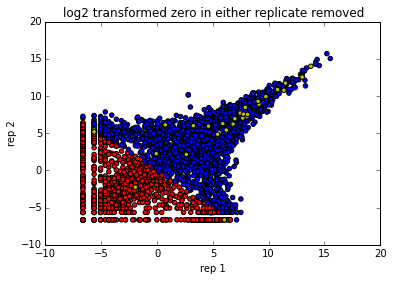

In [17]:
plt.title("log2 transformed zero in either replicate removed")
plt.xlabel("rep 1")
plt.ylabel("rep 2")
colors = []

for i, average in enumerate(A):
    if A.index[i].startswith('gSpike'):
        colors.append('y')
    elif average < Acutoff:
        colors.append('r')
    else:
        colors.append('b')
        
_ = plt.scatter(logrep['rep1'], logrep['rep2'], c=colors)

# Plot ERCC spikes

n is the number of spikes that pass all the thresholds (Bonus plot because it was hard to see the spikes in the full dataset.)

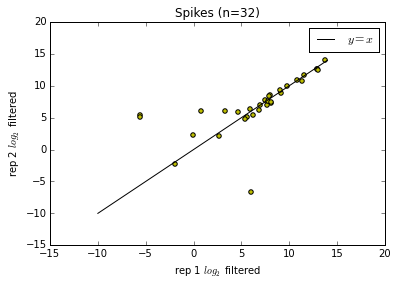

In [18]:
plot_spikes(logrep['rep1'], logrep['rep2'])

## Histogram of log2 transformed data with rows with zeros in either replicate removed

The following plot is a histogram of the $log_2$ transformed data with all rows where either replicate had a zero removed. The red line represents where $A_{cutoff}$ is being applied.

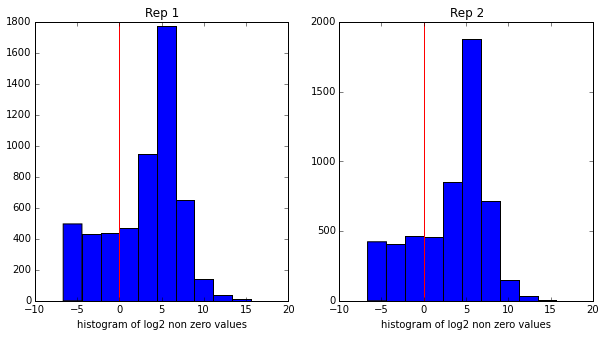

In [19]:
f = plt.figure("12", figsize=(10,5))
plt.subplot("121")
plt.title("Rep 1")

plt.xlabel("histogram of log2 non zero values")
_ = plt.hist(logrep['rep1'])
ymin, ymax = plt.ylim()
plt.vlines(Acutoff, ymin, ymax, color='r')

plt.subplot("122")
plt.title("Rep 2")
plt.xlabel("histogram of log2 non zero values")
plt.hist(logrep['rep2'])
ymin, ymax = plt.ylim()
_ = plt.vlines(Acutoff, ymin, ymax, color='r')


# Pyramidal Neurons

That previous experiment was a probably a bad library, lets try something that correlated better. ENCSR758TAD, RNA-seq on a 50 cell pool of Purkinje cells from an 8 month old male wild type C57Bl6 mouse. I loaded ENCFF593CHP and ENCFF056BVY RSEM Genome quantifications.

## Correlation of raw pyramidal FPKMS

In [20]:
goodreps = load_rsem_reps('ENCFF593CHP.tsv', 'ENCFF056BVY.tsv', 'FPKM')
good_scores = score_replicates(goodreps, None)
pandas.DataFrame(good_scores)


,0
total rows,69690.000000
passed filter,69690.000000
Pearson,0.993685
Spearman,0.923498


## Correlation of log 2 pyramidal FPKMs transformed with no zeros

In [21]:
good_nozero = (goodreps['rep1'] == 0) | (goodreps['rep2'] == 0)

log_good = numpy.log2(goodreps[good_nozero != True])
log_good_scores = score_replicates(goodreps, log_good)
pandas.DataFrame(log_good_scores)

,0
total rows,69690.000000
passed filter,19037.000000
Pearson,0.967659
Spearman,0.978233


## Rafa's QC algorithm on the pyramidal library

In [22]:
Acutoff = 0

M = log_good['rep1'] - log_good['rep2']
A = (log_good['rep1'] + log_good['rep2']) / 2.0

cut_good = log_good[A > Acutoff]

print("MAD of log ratios: ", numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3))
print("SD of log ratios:", numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3))

cut_good_scores = score_replicates(goodreps, cut_good)
pandas.DataFrame(cut_good_scores)

MAD of log ratios:  0.378
SD of log ratios: 0.469


,0
total rows,69690.000000
passed filter,12647.000000
Pearson,0.978679
Spearman,0.974901


# Scatter plot of log2 tranformed pyramidal neurons with zeros in either replicate removed

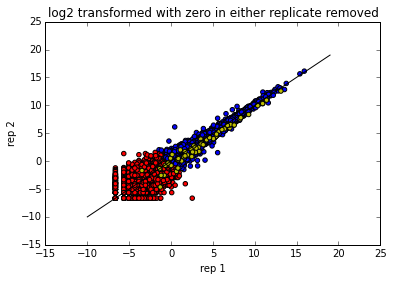

In [23]:
plt.title("log2 transformed with zero in either replicate removed")
plt.xlabel("rep 1")
plt.ylabel("rep 2")
colors = []

for i, average in enumerate(A):
    if A.index[i].startswith('gSpike'):
        colors.append('y')
    elif average < Acutoff:
        colors.append('r')
    else:
        colors.append('b')

_ = plt.scatter(log_good['rep1'], log_good['rep2'], c=colors)
xlim = plt.xlim()
xmin, xmax = int(xlim[0]), int(xlim[1])
_ = plt.plot(range(xmin, xmax), range(xmin, xmax), 'k')

# spikes log2 transformed no zeros

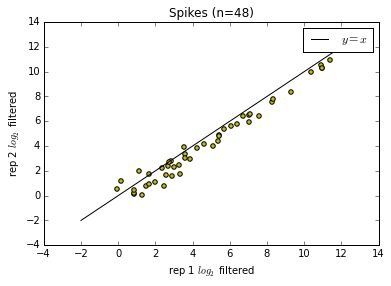

In [24]:
plot_spikes(cut_good['rep1'], cut_good['rep2'])

# Conclusion

With the less good library, we started with 69,690 RSEM FPKM rows and after the combination of dropping either column with a zero and tossing all rows where the average of the $log_2$ transformed FPKM scores of the two replicates was below zero, we ended with only 4,029 rows.

With the better library we started with 69,690 gene ids and ended with 12,647 rows that passed the threshold.

Additionally the spike-ins look much more stable. There are 96 possible spike ins, the poor quality library had 32 that passed the strict A threshold, and and the better library had 48 that were still included.

## Poor library

In [25]:
pandas.DataFrame({'naive': naive_scores,
                  'both zero': bothzero_score,
                  'no zeros': nozero_scores,
                  'log': logrep_scores,
                  'Acutoff': cutrep_scores,},
                 columns = ['naive', 'both zero', 'no zeros', 'log', 'Acutoff',]
                 )


,naive,both zero,no zeros,log,Acutoff
total rows,69690.000000,69690.000000,69690.000000,69690.000000,69690.000000
passed filter,69690.000000,10601.000000,5391.000000,5391.000000,4029.000000
Pearson,0.949737,0.949396,0.949233,0.521577,0.421687
Spearman,0.655810,0.305444,0.633321,0.633321,0.608394


## Better Library

In [26]:
pandas.DataFrame({'naive good': good_scores,
                  'log good': log_good_scores,
                  'Acutoff good': cut_good_scores},
                 columns=['naive good', 'log good', 'Acutoff good'])

,naive good,log good,Acutoff good
total rows,69690.000000,69690.000000,69690.000000
passed filter,69690.000000,19037.000000,12647.000000
Pearson,0.993685,0.967659,0.978679
Spearman,0.923498,0.978233,0.974901
